In [1]:
from nlp_functions import *
sess = tf.Session()

Using TensorFlow backend.


In [2]:
plt.style.use('seaborn')

In [3]:
# Importing our data
sentiment140 = read_sentiment_file(DATA_DIRECTORY, 'sentiment140_train.csv')

In [4]:
# Sampling 10% the data
sentiment140 = sentiment140.sample(frac=0.1, random_state=7)

In [5]:
# Separating into characteristics and labels
X = sentiment140['text']
y = sentiment140['polarity']

In [6]:
# Cleaning the texts
X = clean_data(X)

In [7]:
# Mapping for easier classificacion
y = y.map({0: int(0), 4: int(1)})

In [8]:
# Split the data to train and test, then train and val
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=7)

In [9]:
# Tokenizing the data
tk, word_index, vocab_size = tokenize(X_train, X_val, X_test)

In [10]:
# Each sentence is converted into an array of integers
X_train = tk.texts_to_sequences(X_train)
X_val = tk.texts_to_sequences(X_val)
X_test = tk.texts_to_sequences(X_test)

In [11]:
# Calculation of maximum length to adjust the padding
maxlen = longest_sentence(X_train, X_val, X_test)

In [12]:
# Padding is applied to get the same dimension
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [13]:
# Creating the embedding matrix based on dimension and vocabulary of our texts
EMBEDDING_DIM = 300
embedding_matrix = create_embedding_matrix(vocab_size, EMBEDDING_DIM, word_index)

In [14]:
# Check the ratio of words in our texts are included in the embedding_matrix
print('Using GloVe (Wiki database)')
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

Using GloVe (Wiki database)


0.6430845828750072

In [15]:
# Architecture for CNN + GloVe model
model = Sequential()
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=maxlen,
    trainable=False))
model.add(Conv1D(
    filters=250,
    kernel_size=3,
    activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(
    optimizer='sgd',
    loss='binary_crossentropy',
    metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           15545700  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 48, 250)           225250    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               25100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (De

In [16]:
# Training and validation for CNN + GloVe model
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True)
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping])


Train on 102400 samples, validate on 25600 samples
Epoch 1/100
102400/102400 [==============================] - 9s 91us/step - loss: 0.6300 - accuracy: 0.6402 - precision: 0.6454 - recall: 0.6155 - val_loss: 0.5559 - val_accuracy: 0.7240 - val_precision: 0.7447 - val_recall: 0.6825
Epoch 2/100
102400/102400 [==============================] - 8s 82us/step - loss: 0.5468 - accuracy: 0.7243 - precision: 0.7275 - recall: 0.7134 - val_loss: 0.5160 - val_accuracy: 0.7454 - val_precision: 0.7324 - val_recall: 0.7739
Epoch 3/100
102400/102400 [==============================] - 8s 82us/step - loss: 0.5151 - accuracy: 0.7476 - precision: 0.7494 - recall: 0.7407 - val_loss: 0.4976 - val_accuracy: 0.7563 - val_precision: 0.7567 - val_recall: 0.7559
Epoch 4/100
102400/102400 [==============================] - 8s 82us/step - loss: 0.4967 - accuracy: 0.7608 - precision: 0.7633 - recall: 0.7532 - val_loss: 0.4875 - val_accuracy: 0.7641 - val_precision: 0.7802 - val_recall: 0.7360
Epoch 5/100
102400/1

In [17]:
metrics = pd.DataFrame(history.history)
metrics

,val_loss,val_accuracy,val_precision,val_recall,loss,accuracy,precision,recall
0,0.555945,0.724023,0.744719,0.682460,0.629996,0.640215,0.645450,0.615549
1,0.515950,0.745391,0.732437,0.773944,0.546766,0.724268,0.727547,0.713378
2,0.497629,0.756250,0.756740,0.755913,0.515084,0.747588,0.749425,0.740738
3,0.487519,0.764141,0.780223,0.736008,0.496729,0.760820,0.763302,0.753212
4,0.484411,0.768008,0.807225,0.704707,0.479866,0.772314,0.774002,0.766548
5,0.475231,0.772656,0.794407,0.736242,0.467692,0.780977,0.784005,0.773119
6,0.478088,0.773555,0.820567,0.700726,0.454192,0.789766,0.792979,0.781905
7,0.467249,0.774961,0.760571,0.803138,0.443049,0.796006,0.799411,0.788044
8,0.463788,0.777031,0.770879,0.788931,0.430064,0.803574,0.807433,0.795144
9,0.460816,0.779492,0.786045,0.768558,0.418651,0.809980,0.813129,0.802891


In [18]:
print(f'Best training loss: {metrics.sort_values(by="val_loss", ascending=True).iloc[0,4]}')
print(f'Best training accuracy: {metrics.sort_values(by="val_loss", ascending=True).iloc[0,5]}')
print(f'Best training precision: {metrics.sort_values(by="val_loss", ascending=True).iloc[0,6]}')
print(f'Best training recall: {metrics.sort_values(by="val_loss", ascending=True).iloc[0,7]}')
print('---------------------------------------------')
print(f'Best validation loss: {metrics.sort_values(by="val_loss", ascending=True).iloc[0,0]}')
print(f'Best validation accuracy: {metrics.sort_values(by="val_loss", ascending=True).iloc[0,1]}')
print(f'Best validation precision: {metrics.sort_values(by="val_loss", ascending=True).iloc[0,2]}')
print(f'Best validation recall: {metrics.sort_values(by="val_loss", ascending=True).iloc[0,3]}')

Best training loss: 0.4186511218175292
Best training accuracy: 0.8099804520606995
Best training precision: 0.8131294250488281
Best training recall: 0.802890956401825
---------------------------------------------
Best validation loss: 0.460815689265728
Best validation accuracy: 0.779492199420929
Best validation precision: 0.7860450148582458
Best validation recall: 0.7685582637786865


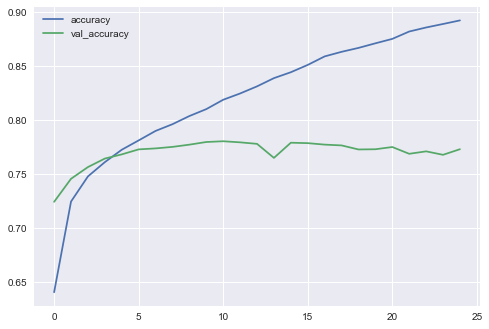

In [19]:
metrics[['accuracy','val_accuracy']].plot()
plt.savefig('../figures/cnn_glove300_acc.jpg', dpi=300)

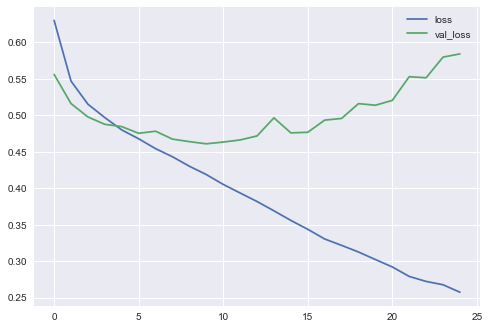

In [20]:
metrics[['loss','val_loss']].plot()
plt.savefig('../figures/cnn_glove300_loss.jpg', dpi=300)

In [21]:
# Evaluation on test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test)

32000/32000 [==============================] - 2s 48us/step


In [22]:
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')
print(f'Test precision: {test_precision}')
print(f'Test recall: {test_recall}')

Test loss: 0.46668752589821816
Test accuracy: 0.7769374847412109
Test precision: 0.7812198996543884
Test recall: 0.7649946212768555


In [23]:
model.save('../models/cnn_glove300.h5')